In [3]:
pip install miceforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install gstreamer-player

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for gstreamer-player: filename=gstreamer_player-1.1.2-py3-none-any.whl size=3783 sha256=25b204f70833fe9bf03d6fe1be14adcf774a36b9e86bbe9378b696e5a513c4b5
  Stored in directory: /root/.cache/pip/wheels/79/76/d0/44b9ff344521029a5778be2761657cce7909faf9c9fb622d78
Successfully built gstreamer-player
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=1948200fee133d684372e2dc2f6a048afc5af855b23646b74eee0e78e0ef0392
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install racplusplus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mno
# import racplusplus
from decimal import Decimal
# from miceforest import ImputationKernel
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor, kneighbors_graph
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage

Steps:
* Linear Regression: done, takes time to converge but converges
* KNN: done, RAM explodes, if the iterations finish before the RAM touches 30GB then you're good
* DecisionTreeRegressor: done, takes 1 hour for 10 iterations and doesn't come close to converging, all over the place.
* Neural Network, small one?: try <br>
(those below depend on DTR's performance)
* RandomForestRegressor: try
* ExtraTreesRegressor: try
* GradientBoostingRegressor: try
* Support Vector Regressor: try
* Code given in ChatGPT
* MissForest?

# MICE

## Setup

In [4]:
std_data = pd.read_csv("/kaggle/input/private-blood-count/standardized_data.csv", index_col = 0)

In [5]:
std_data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,-0.511457,-1.319659,-1.738736,-1.898169,-2.023448,-1.293023,0.445773,-1.127865,-0.404072,0.808224,...,6.582896,0.954797,-0.505317,-0.421533,2.297666,-1.864460,0.978119,2.419403,0.933391,1.322022
1,0.371334,1.584880,1.987492,1.451093,-0.526844,0.467188,1.551324,2.056501,-0.687734,-0.484282,...,8.370188,0.295125,0.309801,0.968668,1.824015,-0.147503,1.303036,2.371645,1.454635,1.808753
2,-0.275433,0.829487,0.810788,0.418614,-1.085101,-0.100622,1.285991,-0.066409,-0.515510,0.004774,...,7.281378,0.743702,0.214235,0.532526,1.924791,-1.082178,0.894569,1.177690,0.419006,1.593686
3,-0.265012,0.893323,0.771565,0.456388,-1.132612,-0.270965,1.064881,-0.169131,-0.637080,-0.030158,...,7.507357,1.165892,-0.016247,0.328085,2.116268,-1.326006,0.486103,2.419403,0.357279,0.937165
4,-0.521266,-1.436691,-1.738736,-1.986307,-1.975937,-0.980727,0.976437,-1.121016,-0.343287,0.878089,...,7.610075,-0.074291,-0.269214,1.459327,2.287588,-1.275208,1.275186,2.562678,0.652194,0.676821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79736,-0.347773,0.840126,1.203023,1.161496,0.470892,0.495578,0.268884,-0.730675,-0.383810,-0.763743,...,-0.566271,-0.628415,-0.584019,-0.121686,-0.987661,-0.431969,-0.293696,-0.446089,-0.438304,0.167451
79737,0.027413,0.765651,0.771565,0.519344,-0.728767,-0.072232,0.843771,2.686527,-1.092966,-0.903474,...,0.214385,0.242351,-0.297322,0.655191,0.917023,0.985283,0.021937,-0.684880,-0.218833,-0.602263
79738,-0.467931,-0.447233,-0.444362,-0.764960,-0.942567,-0.043841,1.197547,-1.011447,-0.697865,-0.379484,...,1.755154,1.957497,0.231099,-0.707751,0.503837,-1.717147,-1.398412,-1.998231,-4.395645,-3.794313
79739,-0.203094,0.935880,0.693118,0.557117,-1.001956,-0.469699,0.489995,-1.340156,-1.174013,-0.693878,...,-0.011594,-0.047904,0.394123,0.627932,5.714002,3.159419,1.108086,0.103130,-0.342285,-0.839969


In [15]:
std_data.isna().sum().sum()

20040

## KNeighborsRegressor

In [5]:
imputer = IterativeImputer(estimator = KNeighborsRegressor(), max_iter = 30, random_state = 0, verbose = 2, initial_strategy = 'mean', tol = 5e-3)
imputed_data = imputer.fit_transform(std_data)

[IterativeImputer] Completing matrix with shape (79741, 64)
[IterativeImputer] Ending imputation round 1/30, elapsed time 9.90
[IterativeImputer] Change: 345.06577971670526, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending imputation round 2/30, elapsed time 20.00
[IterativeImputer] Change: 65.94256361637767, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending imputation round 3/30, elapsed time 31.30
[IterativeImputer] Change: 10.63188797417502, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending imputation round 4/30, elapsed time 41.48
[IterativeImputer] Change: 3.9801907511991144, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending imputation round 5/30, elapsed time 51.53
[IterativeImputer] Change: 3.6547133380625367, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending imputation round 6/30, elapsed time 62.82
[IterativeImputer] Change: 4.456030629507953, scaled tolerance: 0.7666135958367972 
[IterativeImputer] Ending 

In [9]:
imputed_data = pd.DataFrame(imputed_data, columns = std_data.columns)

In [12]:
imputed_data.isna().sum().sum()

0

## DecisionTreeRegressor

In [29]:
nan_rows = std_data[std_data.isna().any(axis=1)]
non_nan_rows = std_data[~std_data.isna().any(axis=1)].sample(n = 501)
std_data_sample = pd.concat([nan_rows, non_nan_rows])
std_data_sample = std_data_sample.copy()
std_data_sample.reset_index(drop = True, inplace = True)
std_data_sample.rename(columns = dict(zip(std_data_sample.columns, list(map(str, range(len(std_data_sample.columns)))))), inplace = True)
std_data_sample

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.438505,0.148569,1.516811,1.325181,2.798943,2.539693,0.666883,-0.182827,0.061946,-1.287732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005343,-0.819610,-0.875820,-0.777551,0.209580,-0.185794,-0.571335,0.673185,0.912934,0.808224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.214742,1.010355,0.497001,1.237043,0.233336,-0.895556,-1.765330,-0.237612,0.294954,0.039707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.084162,-1.766511,-1.464172,-1.117514,3.487856,1.091778,-1.853774,-0.039017,4.448586,2.380191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.238037,0.595421,0.300883,0.708212,0.067047,-0.583261,-1.057777,-0.107498,-0.981528,-1.078137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.266502,-1.266462,-1.268055,-1.318973,0.007658,-0.043841,-0.040670,-0.847093,1.064896,1.087685,...,-0.710076,0.585381,0.500932,-0.067168,-0.312455,0.807492,-0.516496,-0.995308,0.199534,-0.873927
998,-0.200028,-0.989839,-0.797373,-0.651639,1.290461,0.467188,-0.704001,-0.826548,1.733529,1.646607,...,-0.011594,-0.311773,0.433474,0.450750,0.342594,2.646363,0.801736,-0.589364,-4.210466,-3.873548
999,-0.173667,-0.883446,-0.679703,-0.702004,0.696571,0.467188,-0.040670,-1.121016,0.001161,-0.414417,...,0.050037,0.374286,-0.308565,-0.339756,-0.433388,0.843050,0.105487,0.461317,0.960825,0.540989
1000,-0.114201,0.957159,1.242246,1.111131,0.090802,0.353626,0.534217,-0.141738,-0.728257,-0.903474,...,-0.155399,-0.681189,-0.286079,-0.298868,-0.110902,-0.274497,-0.692879,-0.040144,0.069223,0.654182


Turns out Decision Tree doesn't even converge.

In [6]:
imputer = IterativeImputer(estimator = DecisionTreeRegressor(), max_iter = 10, random_state = 0, verbose = 2, initial_strategy = 'mean', tol = 1e-3)
imputed_data = imputer.fit_transform(std_data)

[IterativeImputer] Completing matrix with shape (79741, 64)
[IterativeImputer] Ending imputation round 1/10, elapsed time 363.51
[IterativeImputer] Change: 149.62384199358507, scaled tolerance: 0.15332271916735946 
[IterativeImputer] Ending imputation round 2/10, elapsed time 725.63
[IterativeImputer] Change: 82.06416519285864, scaled tolerance: 0.15332271916735946 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1086.93
[IterativeImputer] Change: 96.54185848167805, scaled tolerance: 0.15332271916735946 
[IterativeImputer] Ending imputation round 4/10, elapsed time 1448.67
[IterativeImputer] Change: 117.86156913068072, scaled tolerance: 0.15332271916735946 
[IterativeImputer] Ending imputation round 5/10, elapsed time 1810.10
[IterativeImputer] Change: 117.51977268276629, scaled tolerance: 0.15332271916735946 
[IterativeImputer] Ending imputation round 6/10, elapsed time 2172.97
[IterativeImputer] Change: 72.6439135066544, scaled tolerance: 0.15332271916735946 
[Iterative

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


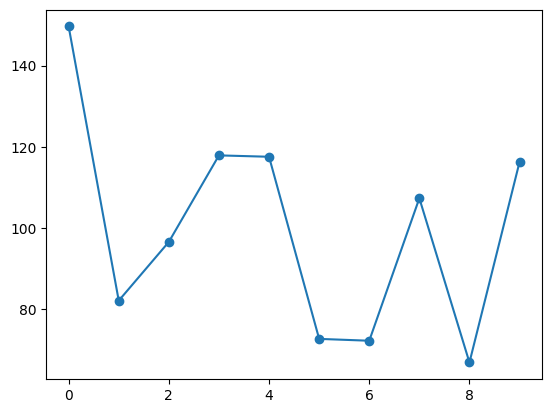

In [4]:
l = [149.62384199358507, 82.06416519285864, 96.54185848167805, 117.86156913068072, 117.51977268276629, 72.6439135066544, 72.18719578980105, 107.29321178210058, 66.82983805416409, 116.22941735312384]
plt.plot(range(len(l)), l, marker = 'o')
plt.show()

## MLPRegressor

In [ ]:
nn_regressor = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam', max_iter=50, random_state=0)
imputer = IterativeImputer(estimator=nn_regressor, max_iter=10, random_state=0, verbose=2, initial_strategy='mean', tol=1e-3)
imputed_data = imputer.fit_transform(std_data)

# KNNIMPUTER

In [16]:
tic = time.time()
imputer = KNNImputer(n_neighbors = 1)
imputer.fit_transform(std_data, )
toc = time.time()
print(f"{toc - tic} seconds")

46.5689218044281 seconds


# MiceForest

In [33]:
mice_kernel = ImputationKernel(
    data = std_data_sample,
    save_all_iterations_data = True,
    random_state = 2023,
)

In [35]:
mice_kernel.mice(2, verbose = True)

Initialized logger with name MICE Iterations 2 - 3 and 4 levels
2 Dataset 0
 | 16 | 17 | 46 | 47 | 48 | 49 | 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 | 60 | 61 | 62 | 45 | 44 | 43 | 25 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 26 | 42 | 27 | 36 | 37 | 38 | 39 | 40 | 41 | 63
3 Dataset 0
 | 16 | 17 | 46 | 47 | 48 | 49 | 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 | 60 | 61 | 62 | 45 | 44 | 43 | 25 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 26 | 42 | 27 | 36 | 37 | 38 | 39 | 40 | 41 | 63


In [ ]:
mice_imputation = mice_kernel.complete_data()
mice_imputation

# Drop the missing rows
To standardize or not to standardize, that is the question

In [3]:
data = pd.read_csv("/kaggle/input/private-blood-count/30_sep_edit.csv")

In [4]:
data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,3.02,2.42,5.6,17.8,73.6,23.1,31.5,87.0,49.0,18.6,...,95.6,357.0,580.0,657.0,772.0,602.0,706.0,368.0,837.0,743.0
1,17.42,5.15,15.1,44.4,86.2,29.3,34.0,552.0,46.2,14.9,...,104.3,332.0,725.0,759.0,725.0,940.0,741.0,366.0,913.0,786.0
2,6.87,4.44,12.1,36.2,81.5,27.3,33.4,242.0,47.9,16.3,...,99.0,349.0,708.0,727.0,735.0,756.0,697.0,316.0,762.0,767.0
3,7.04,4.50,12.0,36.5,81.1,26.7,32.9,227.0,46.7,16.2,...,100.1,365.0,667.0,712.0,754.0,708.0,653.0,368.0,753.0,709.0
4,2.86,2.31,5.6,17.1,74.0,24.2,32.7,88.0,49.6,18.8,...,100.6,318.0,622.0,795.0,771.0,718.0,738.0,374.0,796.0,686.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79736,5.69,4.45,13.1,42.1,94.6,29.4,31.1,145.0,49.2,14.1,...,60.8,297.0,566.0,679.0,446.0,884.0,569.0,248.0,637.0,641.0
79737,11.81,4.38,12.0,37.0,84.5,27.4,32.4,644.0,42.2,13.7,...,64.6,330.0,617.0,736.0,635.0,1163.0,603.0,238.0,669.0,573.0
79738,3.73,3.24,8.9,26.8,82.7,27.5,33.2,104.0,46.1,15.2,...,72.1,395.0,711.0,636.0,594.0,631.0,450.0,183.0,60.0,291.0
79739,8.05,4.54,11.8,37.3,82.2,26.0,31.6,56.0,41.4,14.3,...,63.5,319.0,740.0,734.0,1111.0,1591.0,720.0,271.0,651.0,552.0


In [5]:
data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,3.02,2.42,5.6,17.8,73.6,23.1,31.5,87.0,49.0,18.6,...,95.6,357.0,580.0,657.0,772.0,602.0,706.0,368.0,837.0,743.0
1,17.42,5.15,15.1,44.4,86.2,29.3,34.0,552.0,46.2,14.9,...,104.3,332.0,725.0,759.0,725.0,940.0,741.0,366.0,913.0,786.0
2,6.87,4.44,12.1,36.2,81.5,27.3,33.4,242.0,47.9,16.3,...,99.0,349.0,708.0,727.0,735.0,756.0,697.0,316.0,762.0,767.0
3,7.04,4.50,12.0,36.5,81.1,26.7,32.9,227.0,46.7,16.2,...,100.1,365.0,667.0,712.0,754.0,708.0,653.0,368.0,753.0,709.0
4,2.86,2.31,5.6,17.1,74.0,24.2,32.7,88.0,49.6,18.8,...,100.6,318.0,622.0,795.0,771.0,718.0,738.0,374.0,796.0,686.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79736,5.69,4.45,13.1,42.1,94.6,29.4,31.1,145.0,49.2,14.1,...,60.8,297.0,566.0,679.0,446.0,884.0,569.0,248.0,637.0,641.0
79737,11.81,4.38,12.0,37.0,84.5,27.4,32.4,644.0,42.2,13.7,...,64.6,330.0,617.0,736.0,635.0,1163.0,603.0,238.0,669.0,573.0
79738,3.73,3.24,8.9,26.8,82.7,27.5,33.2,104.0,46.1,15.2,...,72.1,395.0,711.0,636.0,594.0,631.0,450.0,183.0,60.0,291.0
79739,8.05,4.54,11.8,37.3,82.2,26.0,31.6,56.0,41.4,14.3,...,63.5,319.0,740.0,734.0,1111.0,1591.0,720.0,271.0,651.0,552.0


In [6]:
nan_slice = data.isna().sum(axis = 1) != 0
good_slice = ~nan_slice
good_data = data[good_slice].copy()
nan_data = data[nan_slice]
good_data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,3.02,2.42,5.6,17.8,73.6,23.1,31.5,87.0,49.0,18.6,...,95.6,357.0,580.0,657.0,772.0,602.0,706.0,368.0,837.0,743.0
1,17.42,5.15,15.1,44.4,86.2,29.3,34.0,552.0,46.2,14.9,...,104.3,332.0,725.0,759.0,725.0,940.0,741.0,366.0,913.0,786.0
2,6.87,4.44,12.1,36.2,81.5,27.3,33.4,242.0,47.9,16.3,...,99.0,349.0,708.0,727.0,735.0,756.0,697.0,316.0,762.0,767.0
3,7.04,4.50,12.0,36.5,81.1,26.7,32.9,227.0,46.7,16.2,...,100.1,365.0,667.0,712.0,754.0,708.0,653.0,368.0,753.0,709.0
4,2.86,2.31,5.6,17.1,74.0,24.2,32.7,88.0,49.6,18.8,...,100.6,318.0,622.0,795.0,771.0,718.0,738.0,374.0,796.0,686.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79736,5.69,4.45,13.1,42.1,94.6,29.4,31.1,145.0,49.2,14.1,...,60.8,297.0,566.0,679.0,446.0,884.0,569.0,248.0,637.0,641.0
79737,11.81,4.38,12.0,37.0,84.5,27.4,32.4,644.0,42.2,13.7,...,64.6,330.0,617.0,736.0,635.0,1163.0,603.0,238.0,669.0,573.0
79738,3.73,3.24,8.9,26.8,82.7,27.5,33.2,104.0,46.1,15.2,...,72.1,395.0,711.0,636.0,594.0,631.0,450.0,183.0,60.0,291.0
79739,8.05,4.54,11.8,37.3,82.2,26.0,31.6,56.0,41.4,14.3,...,63.5,319.0,740.0,734.0,1111.0,1591.0,720.0,271.0,651.0,552.0


# Dealing with labelled data

In [7]:
for col in data.columns:
    print(col + ':' + ' ' * (20-len(col)) + str(data[col].dtype))

WBC(10^3/uL):        float64
RBC(10^6/uL):        float64
HGB(g/dL):           float64
HCT(%):              float64
MCV(fL):             float64
MCH(pg):             float64
MCHC(g/dL):          float64
PLT(10^3/uL):        float64
RDW-SD(fL):          float64
RDW-CV(%):           float64
PDW(fL):             float64
MPV(fL):             float64
P-LCR(%):            float64
PCT(%):              float64
NRBC#(10^3/uL):      float64
NRBC%(%):            float64
NEUT#(10^3/uL):      float64
LYMPH#(10^3/uL):     float64
MONO#(10^3/uL):      float64
EO#(10^3/uL):        float64
BASO#(10^3/uL):      float64
NEUT%(%):            float64
LYMPH%(%):           float64
MONO%(%):            float64
EO%(%):              float64
BASO%(%):            float64
IG#(10^3/uL):        float64
IG%(%):              float64
[PLT-I(10^3/uL)]:    float64
MicroR(%):           float64
MacroR(%):           float64
[TNC(10^3/uL)]:      float64
[WBC-N(10^3/uL)]:    float64
[TNC-N(10^3/uL)]:    float64
[BA-N#(10^3/uL

In [8]:
labelled_data = pd.read_csv("/kaggle/input/private-blood-count/labelled_datapoints.csv")
labelled_data

,Nickname,Analyzer ID,Date,Time,Rack,Position,Sample No.,Sample Inf.,Order Type,Reception Date,...,Unnamed: 351,Unnamed: 352,Unnamed: 353,Unnamed: 354,Unnamed: 355,Unnamed: 356,Unnamed: 357,Unnamed: 358,Unnamed: 359,Unnamed: 360
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XN-3100-1-R,XN-10^49536,9-7-2024,14:12:07,77,3.0,H122,B,Initial,07-09-2024 14:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XN-3100-1-R,XN-10^49536,9-7-2024,14:11:19,77,1.0,H120,B,Initial,07-09-2024 14:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,XN-3100-1-R,XN-10^49536,9-7-2024,14:09:05,76,5.0,H114,B,Initial,07-09-2024 14:06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

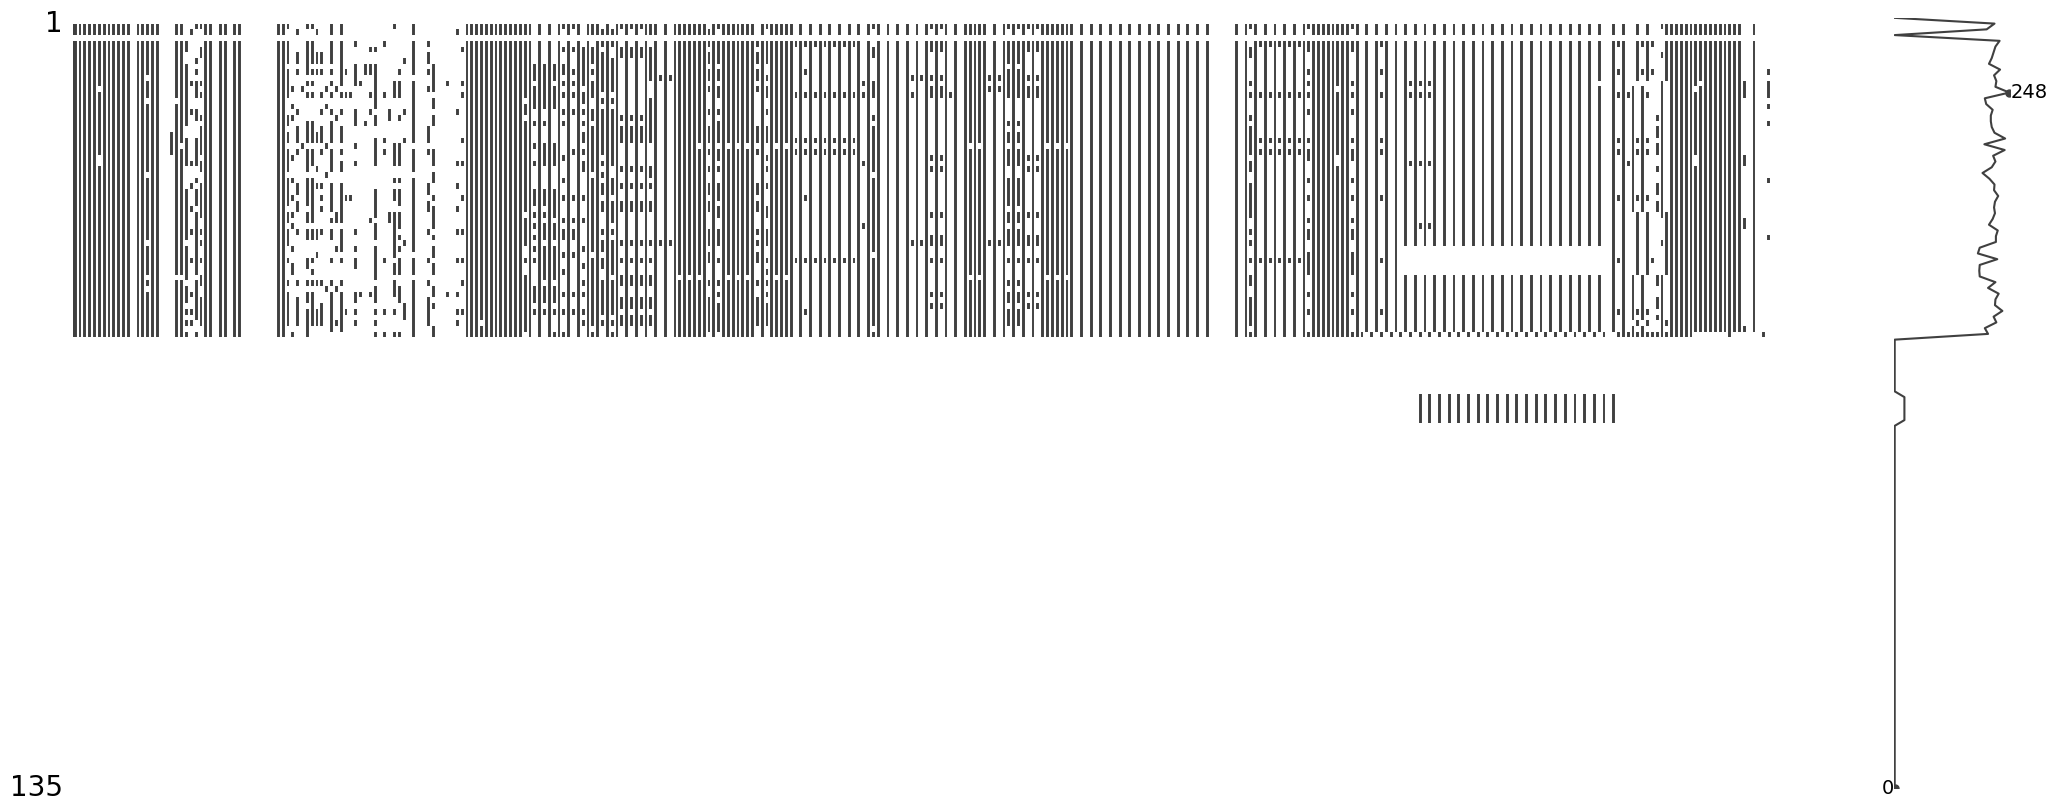

In [9]:
mno.matrix(labelled_data)

In [10]:
# count = 0
length = len(labelled_data.columns)
s = labelled_data.isna().sum(axis = 1)
for i in s.index:
    if s[i]/len(labelled_data) * 100 >= 90:
        print(f'{i}, {s[i]}, {s[i]/length * 100:.2f}')

0, 361, 100.00
1, 145, 40.17
2, 162, 44.88
3, 361, 100.00
4, 134, 37.12
5, 143, 39.61
6, 147, 40.72
7, 151, 41.83
8, 157, 43.49
9, 133, 36.84
10, 146, 40.44
11, 141, 39.06
12, 143, 39.61
14, 166, 45.98
15, 163, 45.15
16, 149, 41.27
17, 153, 42.38
18, 153, 42.38
19, 151, 41.83
20, 145, 40.17
21, 122, 33.80
22, 167, 46.26
23, 123, 34.07
24, 148, 41.00
25, 143, 39.61
26, 151, 41.83
27, 171, 47.37
28, 156, 43.21
29, 145, 40.17
30, 146, 40.44
31, 137, 37.95
32, 144, 39.89
33, 146, 40.44
34, 144, 39.89
35, 149, 41.27
36, 157, 43.49
37, 138, 38.23
38, 142, 39.34
39, 142, 39.34
40, 177, 49.03
41, 181, 50.14
42, 139, 38.50
43, 177, 49.03
44, 178, 49.31
45, 177, 49.03
46, 143, 39.61
47, 159, 44.04
48, 136, 37.67
49, 143, 39.61
50, 144, 39.89
51, 128, 35.46
52, 147, 40.72
53, 141, 39.06
54, 166, 45.98
55, 159, 44.04
56, 361, 100.00
57, 361, 100.00
58, 361, 100.00
59, 361, 100.00
60, 361, 100.00
61, 361, 100.00
62, 361, 100.00
63, 361, 100.00
64, 361, 100.00
65, 361, 100.00
66, 340, 94.18
67, 340,

In [11]:
labelled_data = labelled_data.drop(labelled_data[labelled_data.isna().sum(axis = 1) == 361].index)
labelled_data.reset_index(inplace = True, drop = True)
labelled_data

,Nickname,Analyzer ID,Date,Time,Rack,Position,Sample No.,Sample Inf.,Order Type,Reception Date,...,Unnamed: 351,Unnamed: 352,Unnamed: 353,Unnamed: 354,Unnamed: 355,Unnamed: 356,Unnamed: 357,Unnamed: 358,Unnamed: 359,Unnamed: 360
0,XN-3100-1-R,XN-10^49536,9-7-2024,14:12:07,77,3.0,H122,B,Initial,07-09-2024 14:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XN-3100-1-R,XN-10^49536,9-7-2024,14:11:19,77,1.0,H120,B,Initial,07-09-2024 14:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XN-3100-1-R,XN-10^49536,9-7-2024,14:09:05,76,5.0,H114,B,Initial,07-09-2024 14:06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,XN-3100-1-R,XN-10^49536,9-7-2024,14:07:35,76,1.0,H110,B,Initial,07-09-2024 14:05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,XN-3100-1-L,XN-10^49542,8-7-2024,14:39:25,78,5.0,H122,B,Initial,07-08-2024 14:35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,XN-3100-1-L,XN-10^49542,8-7-2024,14:38:41,78,4.0,H121,B,Initial,07-08-2024 14:35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,XN-3100-1-L,XN-10^49542,7-10-2024,14:44:12,71,2.0,H132,B,Initial,10-07-2024 14:41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,XN-3100-1-L,XN-10^49542,7-10-2024,14:37:24,69,4.0,H123,B,Initial,10-07-2024 14:33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,XN-3100-1-L,XN-10^49542,7-10-2024,14:35:56,69,2.0,H121,B,Initial,10-07-2024 14:33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,XN-3100-1-L,XN-10^49542,11-7-2024,13:54:07,66,3.0,H116,B,Initial,07-11-2024 13:49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
labelled_data.shape

(59, 361)

In [13]:
labelled_data[data.columns]

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[MO-Z(ch)],[NE-WX],[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ]
0,99.41,5.19,13.1,40.5,78.0,25.2,32.3,133.0,39.3,14.6,...,67.7,323.0,700.0,715.0,478.0,1050.0,537.0,302.0,994.0,680.0
1,21.12,4.10,12.1,36.6,89.3,29.5,33.1,464.0,61.2,18.6,...,62.3,332.0,653.0,673.0,391.0,894.0,704.0,367.0,983.0,1155.0
2,52.75,4.05,12.4,38.5,95.1,30.6,32.2,208.0,65.4,19.4,...,57.1,480.0,2137.0,922.0,352.0,759.0,573.0,408.0,1136.0,719.0
3,95.03,4.08,9.4,32.6,79.9,23.0,28.8,273.0,44.4,15.8,...,68.1,332.0,600.0,651.0,505.0,1017.0,563.0,287.0,874.0,573.0
4,98.52,4.21,12.4,41.1,97.6,29.5,30.2,261.0,55.5,15.9,...,64.5,585.0,2509.0,918.0,555.0,1296.0,780.0,412.0,1571.0,853.0
5,138.12,3.79,10.8,35.7,94.2,28.5,30.3,713.0,58.4,17.5,...,72.3,570.0,2335.0,814.0,1213.0,1721.0,992.0,367.0,709.0,1038.0
6,17.57,1.68,5.8,20.1,119.6,34.5,28.9,68.0,83.2,19.1,...,58.4,331.0,804.0,815.0,648.0,2697.0,1676.0,301.0,638.0,736.0
7,327.99,1.41,4.3,16.0,113.5,30.5,26.9,29.0,114.7,29.7,...,61.9,660.0,2728.0,936.0,440.0,1021.0,620.0,431.0,1215.0,856.0
8,10.58,2.14,7.1,23.4,109.3,33.2,30.3,117.0,78.5,19.7,...,63.1,511.0,798.0,889.0,652.0,1001.0,720.0,480.0,878.0,840.0
9,70.83,3.86,7.7,26.4,68.4,19.9,29.2,25.0,58,27.9,...,61.5,484.0,1207.0,983.0,497.0,975.0,649.0,285.0,780.0,634.0


In [14]:
count = 0
s = labelled_data.isna().sum()
for col in s.index:
    if col not in data.columns:
        if s[col]/len(labelled_data) * 100 >= 90:
            print(f'{col}, {s[col]}, {s[col]/len(labelled_data) * 100:.2f}')
            count += 1
print()
print(count)

Patient ID, 59, 100.00
Error(Func.), 59, 100.00
Error(Result), 59, 100.00
Order Info., 55, 93.22
Rule Result, 59, 100.00
Action Message (Check), 59, 100.00
Sample Comment, 59, 100.00
Patient Name, 59, 100.00
Birth, 59, 100.00
Sex, 59, 100.00
Patient Comment, 59, 100.00
Ward Name, 59, 100.00
Doctor Name, 59, 100.00
IP ABN(WBC)Lymphopenia, 57, 96.61
IP ABN(WBC)Leukocytopenia, 54, 91.53
IP ABN(RBC)RBC Abn Distribution, 55, 93.22
IP ABN(RBC)Dimorphic Population, 57, 96.61
IP ABN(RBC)Microcytosis, 57, 96.61
IP ABN(RBC)Macrocytosis, 56, 94.92
IP ABN(RBC)Erythrocytosis, 59, 100.00
IP ABN(RBC)Reticulocytosis, 55, 93.22
IP ABN(PLT)PLT Abn Scattergram, 59, 100.00
IP SUS(WBC)Blasts?, 59, 100.00
IP SUS(WBC)Abn Lympho?, 59, 100.00
IP SUS(RBC)RBC Agglutination?, 59, 100.00
IP SUS(RBC)Turbidity/HGB Interf?, 59, 100.00
IP SUS(RBC)Iron Deficiency?, 57, 96.61
IP SUS(RBC)HGB Defect?, 59, 100.00
NRBC#/M, 57, 96.61
NRBC%/M, 57, 96.61
RET%/M, 54, 91.53
IRF/M, 54, 91.53
LFR/M, 54, 91.53
MFR/M, 54, 91.53
HFR/

In [15]:
data.columns

Index(['WBC(10^3/uL)', 'RBC(10^6/uL)', 'HGB(g/dL)', 'HCT(%)', 'MCV(fL)',
       'MCH(pg)', 'MCHC(g/dL)', 'PLT(10^3/uL)', 'RDW-SD(fL)', 'RDW-CV(%)',
       'PDW(fL)', 'MPV(fL)', 'P-LCR(%)', 'PCT(%)', 'NRBC#(10^3/uL)',
       'NRBC%(%)', 'NEUT#(10^3/uL)', 'LYMPH#(10^3/uL)', 'MONO#(10^3/uL)',
       'EO#(10^3/uL)', 'BASO#(10^3/uL)', 'NEUT%(%)', 'LYMPH%(%)', 'MONO%(%)',
       'EO%(%)', 'BASO%(%)', 'IG#(10^3/uL)', 'IG%(%)', '[PLT-I(10^3/uL)]',
       'MicroR(%)', 'MacroR(%)', '[TNC(10^3/uL)]', '[WBC-N(10^3/uL)]',
       '[TNC-N(10^3/uL)]', '[BA-N#(10^3/uL)]', '[BA-N%(%)]',
       '[WBC-D(10^3/uL)]', '[TNC-D(10^3/uL)]', '[NEUT#&(10^3/uL)]',
       '[NEUT%&(%)]', '[LYMP#&(10^3/uL)]', '[LYMP%&(%)]', '[HFLC#(10^3/uL)]',
       '[HFLC%(%)]', '[BA-D#(10^3/uL)]', '[BA-D%(%)]', '[NE-SSC(ch)]',
       '[NE-SFL(ch)]', '[NE-FSC(ch)]', '[LY-X(ch)]', '[LY-Y(ch)]',
       '[LY-Z(ch)]', '[MO-X(ch)]', '[MO-Y(ch)]', '[MO-Z(ch)]', '[NE-WX]',
       '[NE-WY]', '[NE-WZ]', '[LY-WX]', '[LY-WY]', '[LY-WZ]', '[MO

In [16]:
361-92

269

In [17]:
labelled_data.drop([col for col in labelled_data.columns if labelled_data[col].isna().sum()/len(labelled_data) * 100 >= 90 and col not in data.columns], axis = 1, inplace = True)

In [18]:
labelled_data.iloc[[54, 55, 56, 57, 58], :]

,Nickname,Analyzer ID,Date,Time,Rack,Position,Sample No.,Sample Inf.,Order Type,Reception Date,...,Sample No..2,CELLPACK DCL,SULFOLYSER,Lysercell WNR,Fluorocell WNR,Lysercell WDF,Fluorocell WDF,CELLPACK DFL,Diagnosis,Final diagnosis
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sliced = labelled_data.loc[[54, 55, 56, 57, 58], labelled_data.iloc[[54, 55, 56, 57, 58], :].isna().sum() < 5]
print(sliced.loc[55, 'MN#/M']) #      --> 4 spaces
(sliced.nunique() != 1).sum()

0

In [20]:
labelled_data.drop([54, 55, 56, 57, 58], axis = 0, inplace = True)

In [21]:
269-64

205

<Axes: >

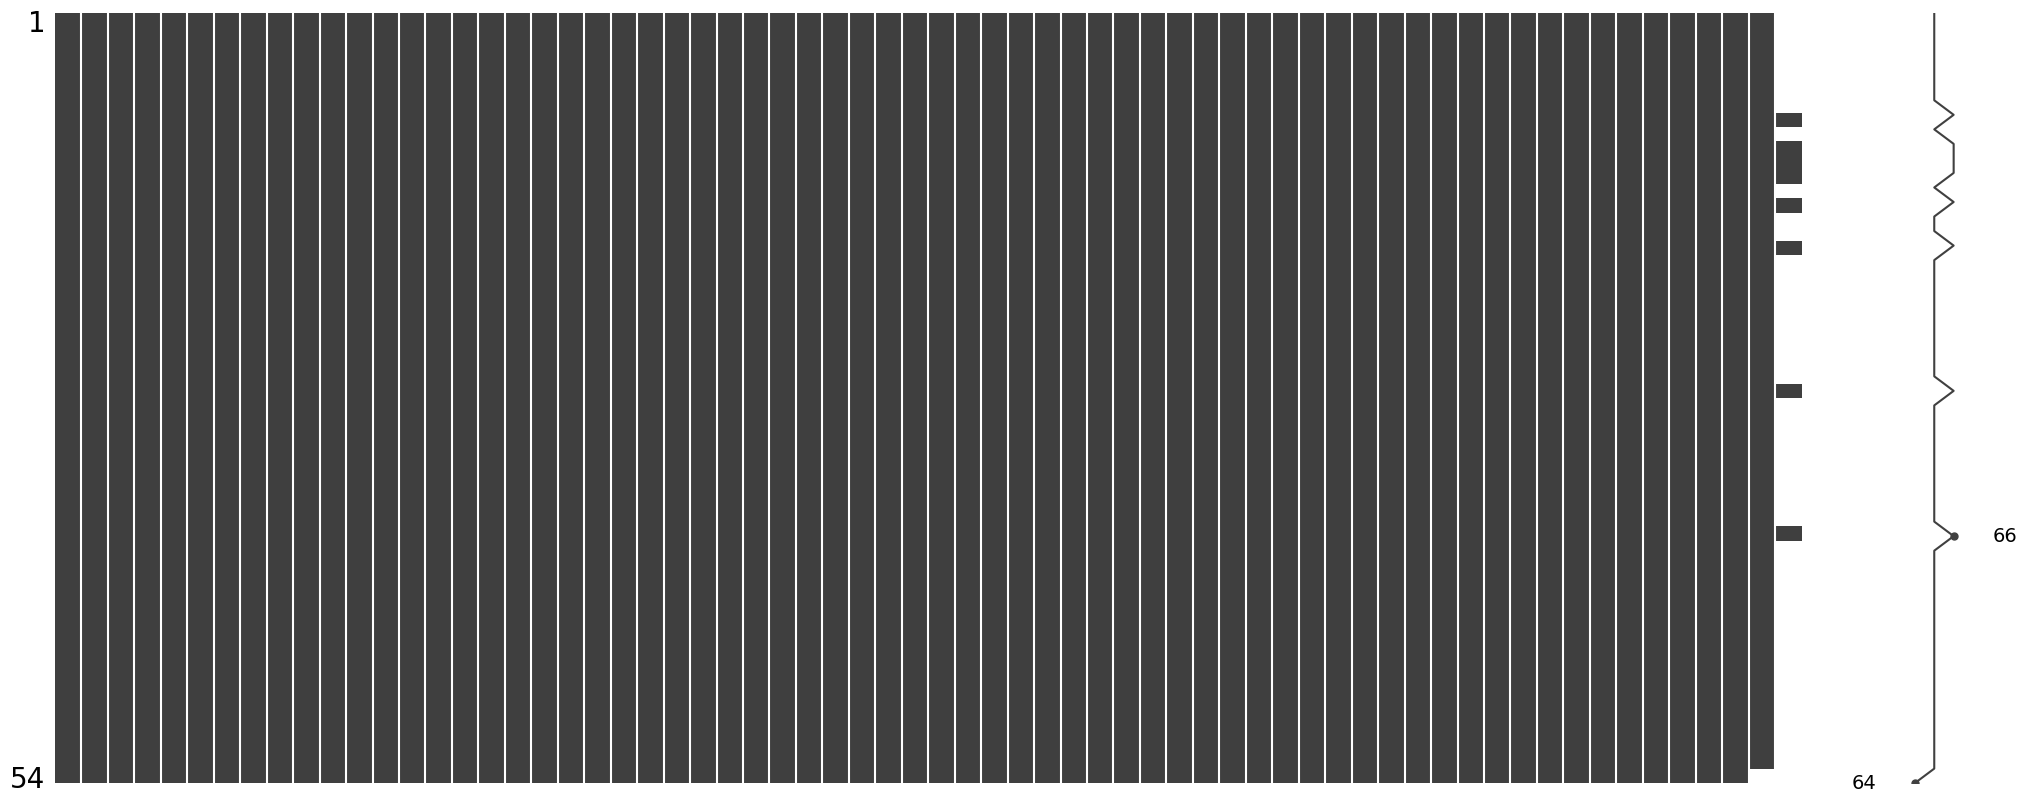

In [22]:
mno.matrix(labelled_data[list(data.columns) + ['Diagnosis', 'Final diagnosis']])

The last entry isn't filled properly.

In [23]:
# lcol_list = [col for col in labelled_data.columns if col not in data.columns]

In [24]:
# labelled_data[lcol_list].to_csv("labelled_ver1.csv", index = False)

In [25]:
final_cols = list(data.columns) + ['Diagnosis', 'Final diagnosis']
labelled_data = labelled_data.loc[:, final_cols]

In [26]:
labelled_data.loc[53, 'Diagnosis'] = 'Acute Leukemia'
labelled_data.loc[53, 'Final diagnosis'] = 'B-Acute lymphoblastic leukemia'

In [27]:
labelled_data

,WBC(10^3/uL),RBC(10^6/uL),HGB(g/dL),HCT(%),MCV(fL),MCH(pg),MCHC(g/dL),PLT(10^3/uL),RDW-SD(fL),RDW-CV(%),...,[NE-WY],[NE-WZ],[LY-WX],[LY-WY],[LY-WZ],[MO-WX],[MO-WY],[MO-WZ],Diagnosis,Final diagnosis
0,99.41,5.19,13.1,40.5,78.0,25.2,32.3,133.0,39.3,14.6,...,700.0,715.0,478.0,1050.0,537.0,302.0,994.0,680.0,Chronic lymphocytic leukemia,NaN
1,21.12,4.10,12.1,36.6,89.3,29.5,33.1,464.0,61.2,18.6,...,653.0,673.0,391.0,894.0,704.0,367.0,983.0,1155.0,Primary Myelofibrosis,NaN
2,52.75,4.05,12.4,38.5,95.1,30.6,32.2,208.0,65.4,19.4,...,2137.0,922.0,352.0,759.0,573.0,408.0,1136.0,719.0,Acute myeloid leukemia,NaN
3,95.03,4.08,9.4,32.6,79.9,23.0,28.8,273.0,44.4,15.8,...,600.0,651.0,505.0,1017.0,563.0,287.0,874.0,573.0,Chronic lymphocytic leukemia,NaN
4,98.52,4.21,12.4,41.1,97.6,29.5,30.2,261.0,55.5,15.9,...,2509.0,918.0,555.0,1296.0,780.0,412.0,1571.0,853.0,"Chronic myeloid leukemia,chronic phase",NaN
5,138.12,3.79,10.8,35.7,94.2,28.5,30.3,713.0,58.4,17.5,...,2335.0,814.0,1213.0,1721.0,992.0,367.0,709.0,1038.0,Chronic myeloid leukemia in chronic phase,NaN
6,17.57,1.68,5.8,20.1,119.6,34.5,28.9,68.0,83.2,19.1,...,804.0,815.0,648.0,2697.0,1676.0,301.0,638.0,736.0,Plasma cell leukemia,NaN
7,327.99,1.41,4.3,16.0,113.5,30.5,26.9,29.0,114.7,29.7,...,2728.0,936.0,440.0,1021.0,620.0,431.0,1215.0,856.0,Acute lymphoblastic leukemia,Early T cell precursor Acute lymphoblastic leu...
8,10.58,2.14,7.1,23.4,109.3,33.2,30.3,117.0,78.5,19.7,...,798.0,889.0,652.0,1001.0,720.0,480.0,878.0,840.0,Acute myeloid leukemia,NaN
9,70.83,3.86,7.7,26.4,68.4,19.9,29.2,25.0,58,27.9,...,1207.0,983.0,497.0,975.0,649.0,285.0,780.0,634.0,Acute lymphoblastic leukemia,B-Acute lymphoblastic leukemia


Let's fix the typos in the labels first.

In [28]:
for i in labelled_data.index:
#     print(i, txt)
    txt = labelled_data.loc[i, 'Diagnosis']
    if re.search("^ ", txt):
        labelled_data.loc[i, 'Diagnosis'] = txt[1:]
    print(i, labelled_data.loc[i, 'Diagnosis'])

0 Chronic lymphocytic leukemia
1 Primary Myelofibrosis
2 Acute myeloid leukemia
3 Chronic lymphocytic leukemia
4 Chronic myeloid leukemia,chronic phase
5 Chronic myeloid leukemia in chronic phase
6 Plasma cell leukemia
7 Acute lymphoblastic leukemia
8 Acute myeloid leukemia
9 Acute lymphoblastic leukemia
10 Acute lymphoblastic leukemia 
11 Acute leukemia
12 Multiple myeloma
13 Acute lymphoblastic leukemia
14 Myeloproliferative neoplasm
15 Acute myelomonocytic leukemia
16 Acute leukemia
17 Chronic myeloid leukemia in chronic phase
18 Chronic myeloid leukemia in chronic phase
19 Chronic myeloid leukemia in chronic phase
20 Aplastic anemia
21 Acute leukemia monocytic
22 Acute lymphoblastic leukemia
23 Acute lymphoblastic leukemia 
24 Chronic lymphocytic leukemia
25 Myelodysplastic neoplasm with increased blasts-2
26 Acute leukemia
27 Chronic myeloid leukemia in chronic phase
28 Acute myelomonocytic leukemia
29 Acute lymphoblastic leukemia
30 Acute myeloid leukemia morphologically monocyti

In [29]:
diag_dict = {}
diag_series = labelled_data.Diagnosis
for i in diag_series.index:
    d = diag_series[i]
    if d not in diag_dict:
        diag_dict[d] = []
    diag_dict[d].append(i)
dd = {i: diag_dict[i] for i in sorted(list(diag_dict.keys()))}
dd

{'Acute Leukemia': [53],
 'Acute leukemia': [11, 16, 26, 36],
 'Acute leukemia monocytic': [21],
 'Acute lymphoblastic leukemia': [7, 9, 13, 22, 29, 41],
 'Acute lymphoblastic leukemia ': [10, 23, 38, 42, 46],
 'Acute myeloid leukemia': [2, 8, 32, 33],
 'Acute myeloid leukemia ': [34],
 'Acute myeloid leukemia morphologically monocytic': [30],
 'Acute myeloid leukemia non M3': [40],
 'Acute myelomonocytic leukemia': [15, 28, 47],
 'Aplastic anemia': [20],
 'Atypical chronic lymphocytic leukemia': [52],
 'Chronic lymphocytic leukemia': [0, 3, 24],
 'Chronic myeloid leukemia chronic phase': [35, 44],
 'Chronic myeloid leukemia in chronic phase': [5,
  17,
  18,
  19,
  27,
  31,
  37,
  49,
  50,
  51],
 'Chronic myeloid leukemia,chronic phase': [4],
 'Multiple myeloma': [12],
 'Myelodysplastic neoplasm with increased blasts-1': [45],
 'Myelodysplastic neoplasm with increased blasts-2': [25],
 'Myelodysplastic syndrome with increased blast type 1': [43],
 'Myeloproliferative neoplasm': [

* Acute leukemia: Acute Leukemia
* Acute leukemia monocytic
* Acute lymphoblastic leukemia: Acute lymphoblastic leukemia 
* Acute myeloid leukemia: Acute myeloid leukemia 
* Acute myeloid leukemia morphologically monocytic
* Acute myeloid leukemia non M3
* Acute myelomonocytic leukemia
* Aplastic anemia
* Atypical chronic lymphocytic leukemia
* Chronic lymphocytic leukemia
* Chronic myeloid leukemia chronic phase: Chronic myeloid leukemia in chronic phase, Chronic myeloid leukemia,chronic phase
* Multiple myeloma
* Myelodysplastic neoplasm with increased blasts-1
* Myelodysplastic neoplasm with increased blasts-2
* Myelodysplastic syndrome with increased blast type 1
* Myeloproliferative neoplasm
* Non Hodgkin lymphoma
* Plasma cell leukemia
* Primary Myelofibrosis: Primary myelofibrosis

In [30]:
# Acute leukemia: Acute Leukemia
dd['Acute leukemia'].extend(dd['Acute Leukemia'])
del dd['Acute Leukemia']
# Acute leukemia monocytic
# Acute lymphoblastic leukemia: Acute lymphoblastic leukemia 
dd['Acute lymphoblastic leukemia'].extend(dd['Acute lymphoblastic leukemia '])
del dd['Acute lymphoblastic leukemia ']
# Acute myeloid leukemia: Acute myeloid leukemia 
dd['Acute myeloid leukemia'].extend(dd['Acute myeloid leukemia '])
del dd['Acute myeloid leukemia ']
# Acute myeloid leukemia morphologically monocytic
# Acute myeloid leukemia non M3
# Acute myelomonocytic leukemia
# Aplastic anemia
# Atypical chronic lymphocytic leukemia
# Chronic lymphocytic leukemia
# Chronic myeloid leukemia chronic phase: Chronic myeloid leukemia in chronic phase, Chronic myeloid leukemia,chronic phase
dd['Chronic myeloid leukemia chronic phase'].extend(dd['Chronic myeloid leukemia in chronic phase'])
del dd['Chronic myeloid leukemia in chronic phase']
dd['Chronic myeloid leukemia chronic phase'].extend(dd['Chronic myeloid leukemia,chronic phase'])
del dd['Chronic myeloid leukemia,chronic phase']
# Multiple myeloma
# Myelodysplastic neoplasm with increased blasts-1: Myelodysplastic syndrome with increased blast type 1
dd['Myelodysplastic neoplasm with increased blasts-1'].extend(dd['Myelodysplastic syndrome with increased blast type 1'])
del dd['Myelodysplastic syndrome with increased blast type 1']
# Myelodysplastic neoplasm with increased blasts-2
# Myeloproliferative neoplasm
# Non Hodgkin lymphoma
# Plasma cell leukemia
# Primary myelofibrosis: Primary Myelofibrosis
dd['Primary myelofibrosis'].extend(dd['Primary Myelofibrosis'])
del dd['Primary Myelofibrosis']

In [31]:
for d in dd.keys():
    for i in dd[d]:
        labelled_data.loc[i, 'Diagnosis'] = d

In [32]:
labelled_data.Diagnosis.nunique()

18

In [33]:
diagnoses = list(labelled_data.Diagnosis.unique())
diagnoses.sort()
diagnoses

['Acute leukemia',
 'Acute leukemia monocytic',
 'Acute lymphoblastic leukemia',
 'Acute myeloid leukemia',
 'Acute myeloid leukemia morphologically monocytic',
 'Acute myeloid leukemia non M3',
 'Acute myelomonocytic leukemia',
 'Aplastic anemia',
 'Atypical chronic lymphocytic leukemia',
 'Chronic lymphocytic leukemia',
 'Chronic myeloid leukemia chronic phase',
 'Multiple myeloma',
 'Myelodysplastic neoplasm with increased blasts-1',
 'Myelodysplastic neoplasm with increased blasts-2',
 'Myeloproliferative neoplasm',
 'Non Hodgkin lymphoma',
 'Plasma cell leukemia',
 'Primary myelofibrosis']

In [34]:
labelled_data.isna().sum().sum()

45

In [35]:
for d in labelled_data.Diagnosis:
    print(d)

Chronic lymphocytic leukemia
Primary myelofibrosis
Acute myeloid leukemia
Chronic lymphocytic leukemia
Chronic myeloid leukemia chronic phase
Chronic myeloid leukemia chronic phase
Plasma cell leukemia
Acute lymphoblastic leukemia
Acute myeloid leukemia
Acute lymphoblastic leukemia
Acute lymphoblastic leukemia
Acute leukemia
Multiple myeloma
Acute lymphoblastic leukemia
Myeloproliferative neoplasm
Acute myelomonocytic leukemia
Acute leukemia
Chronic myeloid leukemia chronic phase
Chronic myeloid leukemia chronic phase
Chronic myeloid leukemia chronic phase
Aplastic anemia
Acute leukemia monocytic
Acute lymphoblastic leukemia
Acute lymphoblastic leukemia
Chronic lymphocytic leukemia
Myelodysplastic neoplasm with increased blasts-2
Acute leukemia
Chronic myeloid leukemia chronic phase
Acute myelomonocytic leukemia
Acute lymphoblastic leukemia
Acute myeloid leukemia morphologically monocytic
Chronic myeloid leukemia chronic phase
Acute myeloid leukemia
Acute myeloid leukemia
Acute myeloid

In [36]:
obj_cols = []
for col in labelled_data.columns:
    print(col + ':' + ' ' * (20-len(col)) + str(labelled_data[col].dtype))
    if labelled_data[col].dtype == 'object':
        obj_cols.append(col)

WBC(10^3/uL):        float64
RBC(10^6/uL):        float64
HGB(g/dL):           float64
HCT(%):              float64
MCV(fL):             float64
MCH(pg):             float64
MCHC(g/dL):          float64
PLT(10^3/uL):        float64
RDW-SD(fL):          object
RDW-CV(%):           object
PDW(fL):             object
MPV(fL):             object
P-LCR(%):            object
PCT(%):              object
NRBC#(10^3/uL):      float64
NRBC%(%):            float64
NEUT#(10^3/uL):      float64
LYMPH#(10^3/uL):     float64
MONO#(10^3/uL):      float64
EO#(10^3/uL):        float64
BASO#(10^3/uL):      float64
NEUT%(%):            float64
LYMPH%(%):           float64
MONO%(%):            float64
EO%(%):              float64
BASO%(%):            float64
IG#(10^3/uL):        float64
IG%(%):              float64
[PLT-I(10^3/uL)]:    float64
MicroR(%):           float64
MacroR(%):           float64
[TNC(10^3/uL)]:      float64
[WBC-N(10^3/uL)]:    float64
[TNC-N(10^3/uL)]:    float64
[BA-N#(10^3/uL)]:   

In [37]:
labelled_data[obj_cols]

,RDW-SD(fL),RDW-CV(%),PDW(fL),MPV(fL),P-LCR(%),PCT(%),Diagnosis,Final diagnosis
0,39.3,14.6,22.1,13.4,51,0.18,Chronic lymphocytic leukemia,NaN
1,61.2,18.6,11.1,9.8,25.3,0.46,Primary myelofibrosis,NaN
2,65.4,19.4,9.8,10.2,25.9,0.21,Acute myeloid leukemia,NaN
3,44.4,15.8,14,11.4,37.9,0.31,Chronic lymphocytic leukemia,NaN
4,55.5,15.9,13.3,11.7,35.9,0.3,Chronic myeloid leukemia chronic phase,NaN
5,58.4,17.5,11.3,10.2,26.5,0.73,Chronic myeloid leukemia chronic phase,NaN
6,83.2,19.1,12.5,11.5,36,0.08,Plasma cell leukemia,NaN
7,114.7,29.7,13.4,9.3,23.9,0.03,Acute lymphoblastic leukemia,Early T cell precursor Acute lymphoblastic leu...
8,78.5,19.7,11.7,10.8,29.8,0.13,Acute myeloid leukemia,NaN
9,58,27.9,----,----,----,----,Acute lymphoblastic leukemia,B-Acute lymphoblastic leukemia


In [38]:
labelled_data.replace({'----': np.nan}, inplace = True)

In [39]:
data.astype?

Signature:
data.astype(
    dtype,
    copy: 'bool_t | None' = None,
    errors: 'IgnoreRaise' = 'raise',
) -> 'Self'
Docstring:
Cast a pandas object to a specified dtype ``dtype``.

Parameters
----------
dtype : str, data type, Series or Mapping of column name -> data type
    Use a str, numpy.dtype, pandas.ExtensionDtype or Python type to
    cast entire pandas object to the same type. Alternatively, use a
    mapping, e.g. {col: dtype, ...}, where col is a column label and dtype is
    a numpy.dtype or Python type to cast one or more of the DataFrame's
    columns to column-specific types.
copy : bool, default True
    Return a copy when ``copy=True`` (be very careful setting
    ``copy=False`` as changes to values then may propagate to other
    pandas objects).

    .. note::
        The `copy` keyword will change behavior in pandas 3.0.
        `Copy-on-Write
        <https://pandas.pydata.org/docs/dev/user_guide/copy_on_write.html>`__
        will be enabled by default, which me

In [40]:
obj_cols

['RDW-SD(fL)',
 'RDW-CV(%)',
 'PDW(fL)',
 'MPV(fL)',
 'P-LCR(%)',
 'PCT(%)',
 'Diagnosis',
 'Final diagnosis']

In [41]:
for col in obj_cols[:-2]:
    labelled_data[col] = labelled_data[col].astype(np.float64)

In [42]:
for col in labelled_data.columns:
    print(col + ':' + ' ' * (20-len(col)) + str(labelled_data[col].dtype))

WBC(10^3/uL):        float64
RBC(10^6/uL):        float64
HGB(g/dL):           float64
HCT(%):              float64
MCV(fL):             float64
MCH(pg):             float64
MCHC(g/dL):          float64
PLT(10^3/uL):        float64
RDW-SD(fL):          float64
RDW-CV(%):           float64
PDW(fL):             float64
MPV(fL):             float64
P-LCR(%):            float64
PCT(%):              float64
NRBC#(10^3/uL):      float64
NRBC%(%):            float64
NEUT#(10^3/uL):      float64
LYMPH#(10^3/uL):     float64
MONO#(10^3/uL):      float64
EO#(10^3/uL):        float64
BASO#(10^3/uL):      float64
NEUT%(%):            float64
LYMPH%(%):           float64
MONO%(%):            float64
EO%(%):              float64
BASO%(%):            float64
IG#(10^3/uL):        float64
IG%(%):              float64
[PLT-I(10^3/uL)]:    float64
MicroR(%):           float64
MacroR(%):           float64
[TNC(10^3/uL)]:      float64
[WBC-N(10^3/uL)]:    float64
[TNC-N(10^3/uL)]:    float64
[BA-N#(10^3/uL

In [43]:
s = labelled_data.isna().sum()/len(labelled_data) * 100
for i in s.index:
    print(i + ':' + ' ' * (20-len(i)) + str(s[i]))

WBC(10^3/uL):        0.0
RBC(10^6/uL):        0.0
HGB(g/dL):           0.0
HCT(%):              0.0
MCV(fL):             0.0
MCH(pg):             0.0
MCHC(g/dL):          0.0
PLT(10^3/uL):        0.0
RDW-SD(fL):          3.7037037037037033
RDW-CV(%):           3.7037037037037033
PDW(fL):             42.592592592592595
MPV(fL):             42.592592592592595
P-LCR(%):            42.592592592592595
PCT(%):              42.592592592592595
NRBC#(10^3/uL):      0.0
NRBC%(%):            0.0
NEUT#(10^3/uL):      0.0
LYMPH#(10^3/uL):     0.0
MONO#(10^3/uL):      0.0
EO#(10^3/uL):        0.0
BASO#(10^3/uL):      0.0
NEUT%(%):            0.0
LYMPH%(%):           0.0
MONO%(%):            0.0
EO%(%):              0.0
BASO%(%):            0.0
IG#(10^3/uL):        0.0
IG%(%):              0.0
[PLT-I(10^3/uL)]:    0.0
MicroR(%):           0.0
MacroR(%):           0.0
[TNC(10^3/uL)]:      0.0
[WBC-N(10^3/uL)]:    0.0
[TNC-N(10^3/uL)]:    0.0
[BA-N#(10^3/uL)]:    0.0
[BA-N%(%)]:          0.0
[WBC-D(10^

In [44]:
for col in data.columns:
    print(col + ':' + ' ' * (20-len(col)) + str(data[col].dtype))

WBC(10^3/uL):        float64
RBC(10^6/uL):        float64
HGB(g/dL):           float64
HCT(%):              float64
MCV(fL):             float64
MCH(pg):             float64
MCHC(g/dL):          float64
PLT(10^3/uL):        float64
RDW-SD(fL):          float64
RDW-CV(%):           float64
PDW(fL):             float64
MPV(fL):             float64
P-LCR(%):            float64
PCT(%):              float64
NRBC#(10^3/uL):      float64
NRBC%(%):            float64
NEUT#(10^3/uL):      float64
LYMPH#(10^3/uL):     float64
MONO#(10^3/uL):      float64
EO#(10^3/uL):        float64
BASO#(10^3/uL):      float64
NEUT%(%):            float64
LYMPH%(%):           float64
MONO%(%):            float64
EO%(%):              float64
BASO%(%):            float64
IG#(10^3/uL):        float64
IG%(%):              float64
[PLT-I(10^3/uL)]:    float64
MicroR(%):           float64
MacroR(%):           float64
[TNC(10^3/uL)]:      float64
[WBC-N(10^3/uL)]:    float64
[TNC-N(10^3/uL)]:    float64
[BA-N#(10^3/uL

In [45]:
new_list = obj_cols[:-2]
new_list

['RDW-SD(fL)', 'RDW-CV(%)', 'PDW(fL)', 'MPV(fL)', 'P-LCR(%)', 'PCT(%)']

In [46]:
data[new_list].isna().sum().sum()

0

In [47]:
data.isna().sum().sum()

20040

<Axes: >

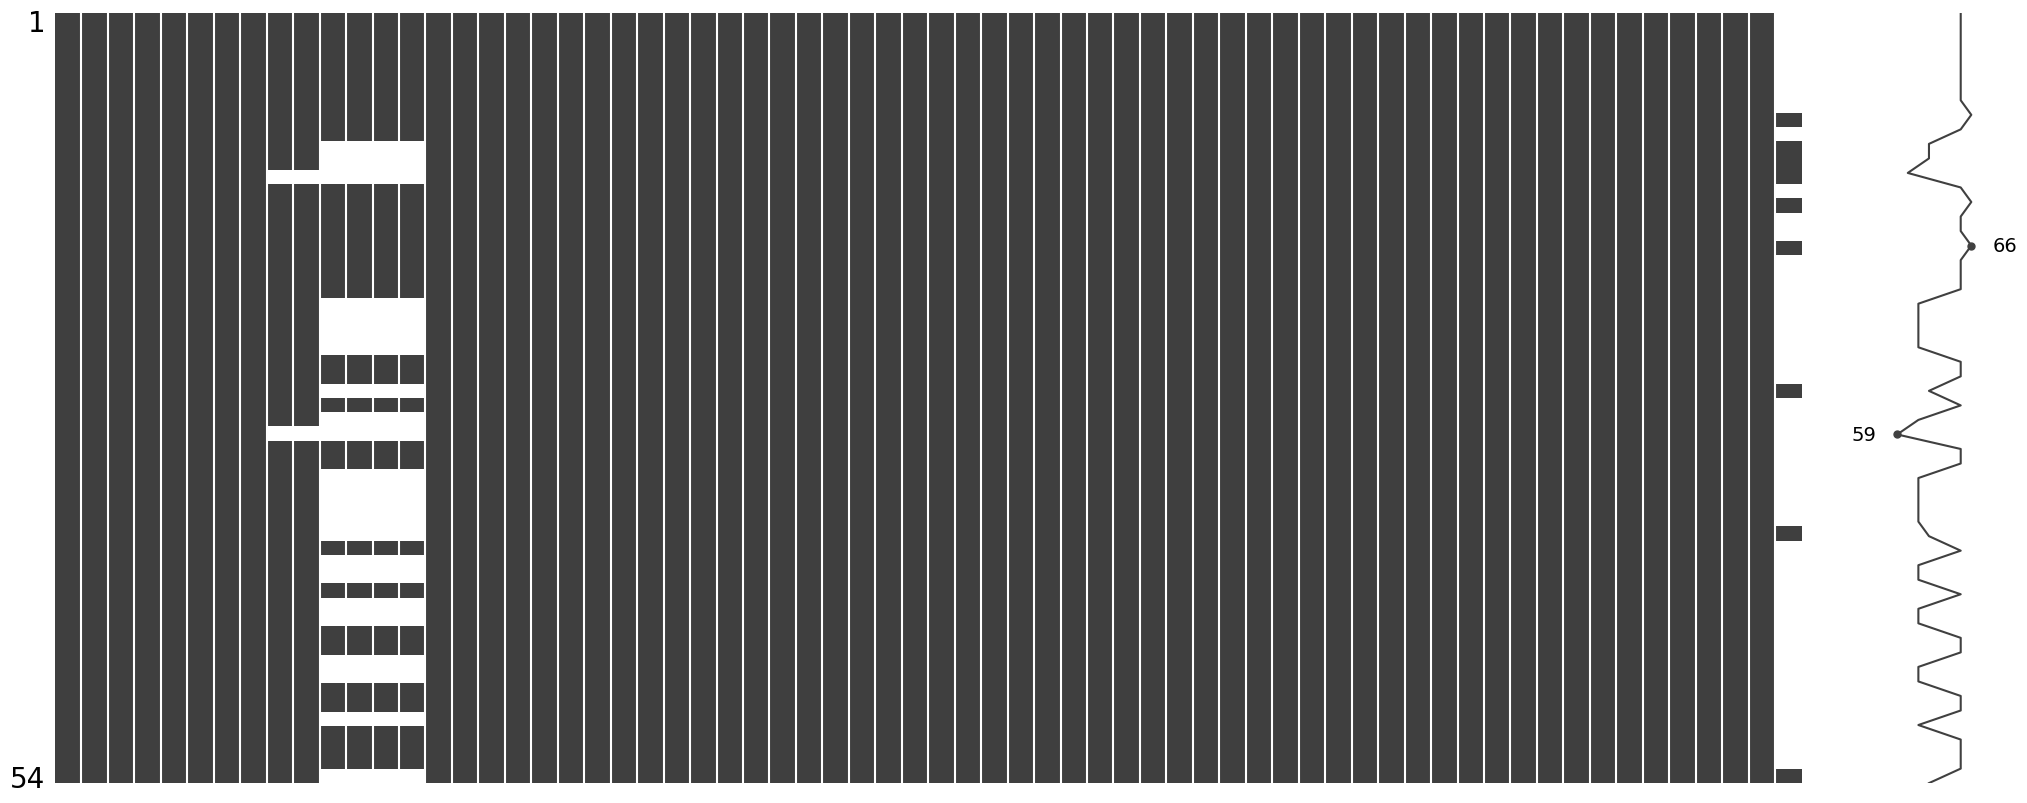

In [48]:
mno.matrix(labelled_data)

In [50]:
labelled_data.to_csv("labelled_necessary_cols.csv", index = False)

In [49]:
labelled_data.Diagnosis.nunique()

18